In [1]:
from google.colab import drive as gdrive
gdrive.mount('/content/drive')
!pip install pytorch-model-summary

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import time as time
from pytorch_model_summary import summary
import random
import os

import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision.models as models
from torch import optim

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(9)


In [0]:
!unzip -qq /content/drive/My\ Drive/hw7/food-11.zip
# !gdown --id '1B8ljdrxYXJsZv2vmTequdPOofp3VF3NN' --output teacher_resnet18.bin
!cp -Rf  /content/drive/My\ Drive/hw7/* ./

# 1. Base Implementation

-  CNN Architecture Design
-  Knowledge Distillation
-  Network Pruning
-  Weight Quantization

我稍微计算了以下，以最后进行weight quantization为基础，我的模型最多0.6M，稍微计算一下最多容许参数153,600, 当前参数为256,779。缩小模型吧。

##  1.0 Summary

In [0]:

class StudentNet(nn.Module):
    '''
      在這個Net裡面，我們會使用Depthwise & Pointwise Convolution Layer來疊model。
      你會發現，將原本的Convolution Layer換成Dw & Pw後，Accuracy通常不會降很多。

      另外，取名為StudentNet是因為這個Model等會要做Knowledge Distillation。
    '''

    def __init__(self, base=16, width_mult=1):
        '''
          Args:
            base: 這個model一開始的ch數量，每過一層都會*2，直到base*16為止。
            width_mult: 為了之後的Network Pruning使用，在base*8 chs的Layer上會 * width_mult代表剪枝後的ch數量。        
        '''
        super(StudentNet, self).__init__()
        multiplier = [1, 2, 4, 8, 16, 16, 16, 16]

        # bandwidth: 每一層Layer所使用的ch數量
        bandwidth = [ base * m for m in multiplier]

        # 我們只Pruning第三層以後的Layer
        for i in range(3, 7):
            bandwidth[i] = int(bandwidth[i] * width_mult)

        self.cnn = nn.Sequential(
            # 第一層我們通常不會拆解Convolution Layer。
            nn.Sequential(
                nn.Conv2d(3, bandwidth[0], 3, 1, 1),
                nn.BatchNorm2d(bandwidth[0]),
                nn.ReLU6(),
                nn.MaxPool2d(2, 2, 0),
            ),
            # 接下來每一個Sequential Block都一樣，所以我們只講一個Block
            nn.Sequential(
                # Depthwise Convolution
                nn.Conv2d(bandwidth[0], bandwidth[0], 3, 1, 1, groups=bandwidth[0]),
                # Batch Normalization
                nn.BatchNorm2d(bandwidth[0]),
                # ReLU6 是限制Neuron最小只會到0，最大只會到6。 MobileNet系列都是使用ReLU6。
                # 使用ReLU6的原因是因為如果數字太大，會不好壓到float16 / or further qunatization，因此才給個限制。
                nn.ReLU6(),
                # Pointwise Convolution
                nn.Conv2d(bandwidth[0], bandwidth[1], 1),
                # 過完Pointwise Convolution不需要再做ReLU，經驗上Pointwise + ReLU效果都會變差。
                nn.MaxPool2d(2, 2, 0),
                # 每過完一個Block就Down Sampling
            ),

            nn.Sequential(
                nn.Conv2d(bandwidth[1], bandwidth[1], 3, 1, 1, groups=bandwidth[1]),
                nn.BatchNorm2d(bandwidth[1]),
                nn.ReLU6(),
                nn.Conv2d(bandwidth[1], bandwidth[2], 1),
                nn.MaxPool2d(2, 2, 0),
            ),

            nn.Sequential(
                nn.Conv2d(bandwidth[2], bandwidth[2], 3, 1, 1, groups=bandwidth[2]),
                nn.BatchNorm2d(bandwidth[2]),
                nn.ReLU6(),
                nn.Conv2d(bandwidth[2], bandwidth[3], 1),
                nn.MaxPool2d(2, 2, 0),
            ),

            # 到這邊為止因為圖片已經被Down Sample很多次了，所以就不做MaxPool
            nn.Sequential(
                nn.Conv2d(bandwidth[3], bandwidth[3], 3, 1, 1, groups=bandwidth[3]),
                nn.BatchNorm2d(bandwidth[3]),
                nn.ReLU6(),
                nn.Conv2d(bandwidth[3], bandwidth[4], 1),
            ),

            nn.Sequential(
                nn.Conv2d(bandwidth[4], bandwidth[4], 3, 1, 1, groups=bandwidth[4]),
                nn.BatchNorm2d(bandwidth[4]),
                nn.ReLU6(),
                nn.Conv2d(bandwidth[5], bandwidth[5], 1),
            ),

            nn.Sequential(
                nn.Conv2d(bandwidth[5], bandwidth[5], 3, 1, 1, groups=bandwidth[5]),
                nn.BatchNorm2d(bandwidth[5]),
                nn.ReLU6(),
                nn.Conv2d(bandwidth[6], bandwidth[6], 1),
            ),

            nn.Sequential(
                nn.Conv2d(bandwidth[6], bandwidth[6], 3, 1, 1, groups=bandwidth[6]),
                nn.BatchNorm2d(bandwidth[6]),
                nn.ReLU6(),
                nn.Conv2d(bandwidth[6], bandwidth[7], 1),
            ),

            # 這邊我們採用Global Average Pooling。
            # 如果輸入圖片大小不一樣的話，就會因為Global Average Pooling壓成一樣的形狀，這樣子接下來做FC就不會對不起來。
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.fc = nn.Sequential(
            # 這邊我們直接Project到11維輸出答案。
            nn.Linear(bandwidth[7], 11),
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

import re
import torch
from glob import glob
from PIL import Image
import torchvision.transforms as transforms

class MyDataset(torch.utils.data.Dataset):

    def __init__(self, folderName, transform=None):
        self.transform = transform
        self.data = []
        self.label = []

        for img_path in sorted(glob(folderName + '/*.jpg')):
            try:
                # Get classIdx by parsing image path
                class_idx = int(re.findall(re.compile(r'\d+'), img_path)[1])
            except:
                # if inference mode (there's no answer), class_idx default 0
                class_idx = 0

            image = Image.open(img_path)
            # Get File Descriptor
            image_fp = image.fp
            image.load()
            # Close File Descriptor (or it'll reach OPEN_MAX)
            image_fp.close()

            self.data.append(image)
            self.label.append(class_idx)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image = self.data[idx]
        if self.transform:
            image = self.transform(image)
        return image, self.label[idx]


trainTransform = transforms.Compose([
    transforms.RandomCrop(256, pad_if_needed=True, padding_mode='symmetric'),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
])
testTransform = transforms.Compose([
    transforms.CenterCrop(256),
    transforms.ToTensor(),
])

def get_dataloader(dataset, mode ='training', batch_size=32):

    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=(mode == 'training'))

    return dataloader

def kd_loss(pred, hard_labels, teacher_pred, T = 20, alpha = 0.5):
    hard_loss = F.cross_entropy(pred, hard_labels) * (1 - alpha)
    # 官方api说，必须用batchmean，其次为什么一个要用log_softmax，因为官方api里面只对一个log
    soft_loss = nn.KLDivLoss(reduction='batchmean')(F.log_softmax(pred/T, dim=1), F.softmax(teacher_pred/T, dim = 1)) * (alpha * T * T)
    return hard_loss+soft_loss
def run_epoch(data_loader, mode = 'train', alpha = 0.5, learning_rate = 1e-3):
    optimizer = optim.AdamW(student_net.parameters(), lr=learning_rate)
    total_hit, total_num, total_loss = 0, 0, 0
    loss_func = kd_loss
    for i, (x_batch, y_batch) in enumerate(data_loader):
        optimizer.zero_grad()
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device, dtype = torch.long)
        with torch.no_grad():
            soft_labels = teacher_net(x_batch)
        if mode == 'train':
            pred_batch = student_net(x_batch)
            loss = loss_func(pred_batch, y_batch, soft_labels, 20, alpha)
            loss.backward()
            optimizer.step()
        elif mode == 'eval':
            with torch.no_grad():
                pred_batch = student_net(x_batch)
                loss = loss_func(pred_batch, y_batch, soft_labels, 20, alpha)
        total_hit += torch.sum(pred_batch.max(1)[1]==y_batch).item()
        total_num += len(x_batch)
        total_loss += loss.item() * len(x_batch)
    return total_loss/total_num, total_hit/total_num

def run_epoch_pruning(data_loader, mode = 'train'):
    total_loss, hits, num = 0, 0, 0
    loss_fun = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    for i, (x_batch, y_batch) in enumerate(data_loader):
        optimizer.zero_grad()
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device, dtype = torch.long)
        pred_batch = net(x_batch)
        loss = loss_fun(pred_batch, y_batch)
        if mode == 'train':
            loss.backward()
            optimizer.step()
        hits += torch.sum(pred_batch.max(1)[1]==y_batch).item()
        total_loss += loss.item() * len(y_batch)
        num += len(y_batch)
    return total_loss/num, hits/num

def to_float16(params):
    for name,p in params.items():
        if p.shape != torch.Size([]):
            params[name] =  p.to(device, dtype = torch.float16)
    return params

In [0]:
device = torch.device('cuda')
# dataset
train_set = MyDataset(
    f'./food-11/training',
    transform=trainTransform)
val_set = MyDataset(
    f'./food-11/validation',
    transform=testTransform)
test_set = MyDataset(
    f'./food-11/testing',
    transform=testTransform
)

In [0]:
# get dataloader
train_dataloader = get_dataloader(train_set, 'training',batch_size=64)
valid_dataloader = get_dataloader(val_set, 'eval', batch_size=64)
# net init
teacher_net = models.resnet18(pretrained=False, num_classes=11).to(device)
student_net = StudentNet(base=16).to(device)
teacher_net.load_state_dict(torch.load(f'./teacher_resnet18.bin'))
# training student_net
alpha = 0.5
epochs = 200

SyntaxError: invalid syntax (<ipython-input-41-4414fc617837>, line 2)

In [0]:
teacher_net.eval()
now_best_acc = 0
for epoch in range(epochs):
    start_time = time.time()
    student_net.train()
    train_loss, train_acc = run_epoch(train_dataloader, mode = 'train', alpha = alpha)
    student_net.eval()
    val_loss, val_acc = run_epoch(valid_dataloader, mode='eval', alpha = alpha)
    end_time = time.time()
    if val_acc > now_best_acc:
        now_best_acc = val_acc
        torch.save(student_net.state_dict(), 'student_model.bin')
        print('{:4.2f}s, epoch{:>3d}: train loss: {:6.4f}, acc {:6.4f} valid loss: {:6.4f}, acc {:6.4f}'.format(end_time - start_time, epoch, train_loss, train_acc, val_loss, val_acc))
        

## 1.1 CNN Architecture Design

CNN架构设计，利用Depthwise & Pointwise Convolution进行设计架构。具体实现方式在pytorch中很简单，
- Depthwise设置cnn group = input features，那么每一层都会分开卷积。
- Pointwise其实就是设置filter size = 1

In [0]:
class StudentNet(nn.Module):
    def __init__(self, base=16, width_mult = 1):
        super(StudentNet, self).__init__()
        multiplier = [1, 2, 4, 8, 16, 16, 16, 16]

        # bandwidth: 每一層Layer所使用的ch數量
        bandwidth = [ base * m for m in multiplier]

        # 我們只Pruning第三層以後的Layer
        for i in range(3, 7):
            bandwidth[i] = int(bandwidth[i] * width_mult)
        
        layers = self.init_cnn_layers(bandwidth)
        self.cnn = nn.Sequential(*layers)
        self.fc = nn.Sequential(
            nn.Linear(bandwidth[-1], 11)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

    def init_cnn_layers(self, bandwidth):
        def cnn_block(in_c, out_c, downsampling = True):
            if downsampling:
                return nn.Sequential(
                    nn.Conv2d(in_c, in_c, 3, 1, 1, groups=in_c),
                    nn.BatchNorm2d(in_c),
                    nn.ReLU6(),
                    nn.Conv2d(in_c, out_c, 1),
                    nn.MaxPool2d(2, 2, 0),
                )
            return nn.Sequential(
                    nn.Conv2d(in_c, in_c, 3, 1, 1, groups=in_c),
                    nn.BatchNorm2d(in_c),
                    nn.ReLU6(),
                    nn.Conv2d(in_c, out_c, 1),
                )

        layers = []
        layers.append(cnn_block(3, bandwidth[0]))
        downsampling = True
        for i in range(len(bandwidth)-1):
            if i == 2:
                downsampling = False
            layers.append(cnn_block(bandwidth[i], bandwidth[i+1], downsampling = downsampling))

        # notes: 這邊我們採用Global Average Pooling。
        # 如果輸入圖片大小不一樣的話，就會因為Global Average Pooling壓成一樣的形狀，這樣子接下來做FC就不會對不起來。         
        layers.append(nn.AdaptiveAvgPool2d((1,1)))
        return layers
        
        

In [0]:
print(summary(StudentNet(),  torch.zeros(1,3,128,128)))

------------------------------------------------------------------------------
           Layer (type)          Output Shape         Param #     Tr. Param #
               Conv2d-1      [1, 3, 128, 128]              30              30
          BatchNorm2d-2      [1, 3, 128, 128]               6               6
                ReLU6-3      [1, 3, 128, 128]               0               0
               Conv2d-4     [1, 16, 128, 128]              64              64
            MaxPool2d-5       [1, 16, 64, 64]               0               0
               Conv2d-6       [1, 16, 64, 64]             160             160
          BatchNorm2d-7       [1, 16, 64, 64]              32              32
                ReLU6-8       [1, 16, 64, 64]               0               0
               Conv2d-9       [1, 32, 64, 64]             544             544
           MaxPool2d-10       [1, 32, 32, 32]               0               0
              Conv2d-11       [1, 32, 32, 32]             320  

## 1.2 Konwledge Distillation

思想是让small student net 学习large teacher net，唯一值得注意的是对于student net，它有两个目标。
- 分类任务本身
- 分布尽量和teacher net的结果像。

从这一点来看，为什么会有效？因为teacher net对于各个分类的概率分布肯定是准得多，它可以识别出更多东西，这些知识，也会被student学到。

这个任务的重点是loss function的写法——如何描述分布相似？

$$Loss = \alpha T^2 \times KL(\frac{\text{Teacher's Logits}}{T} || \frac{\text{Student's Logits}}{T}) + (1-\alpha)$$

相对熵公式

$$\begin{aligned}
\mathrm{D}(\mathrm{P} \| \mathrm{Q})=H^{\prime}(x)-H(x) &=\sum_{x \in X} P(x) * \log \left(\frac{1}{Q(x)}\right)-\sum_{x \in X} P(x) * \log \left(\frac{1}{P(x)}\right) \\
&=\sum_{x \in X} P(x) *\left[\log \left(\frac{P(x)}{Q(x)}\right)\right]
\end{aligned}$$


In [0]:
import re
import torch
from glob import glob
from PIL import Image
import torchvision.transforms as transforms

class MyDataset(torch.utils.data.Dataset):

    def __init__(self, folderName, transform=None):
        self.transform = transform
        self.data = []
        self.label = []

        for img_path in sorted(glob(folderName + '/*.jpg')):
            try:
                # Get classIdx by parsing image path
                class_idx = int(re.findall(re.compile(r'\d+'), img_path)[1])
            except:
                # if inference mode (there's no answer), class_idx default 0
                class_idx = 0

            image = Image.open(img_path)
            # Get File Descriptor
            image_fp = image.fp
            image.load()
            # Close File Descriptor (or it'll reach OPEN_MAX)
            image_fp.close()

            self.data.append(image)
            self.label.append(class_idx)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image = self.data[idx]
        if self.transform:
            image = self.transform(image)
        return image, self.label[idx]


trainTransform = transforms.Compose([
    transforms.RandomCrop(256, pad_if_needed=True, padding_mode='symmetric'),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
])
testTransform = transforms.Compose([
    transforms.CenterCrop(256),
    transforms.ToTensor(),
])

def get_dataloader(dataset, batch_size=32):

    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=(mode == 'training'))

    return dataloader


In [0]:
device = torch.device('cuda')
# dataset
train_set = MyDataset(
    f'./food-11/{mode}',
    transform=trainTransform if mode == 'training' else testTransform)
val_set = MyDataset(
    f'./food-11/{mode}',
    transform=trainTransform if mode == 'training' else testTransform)
# get dataloader
train_dataloader = get_dataloader(train_set, batch_size=64)
valid_dataloader = get_dataloader(val_set, batch_size=64)
# net init
teacher_net = models.resnet18(pretrained=False, num_classes=11).to(device)
student_net = StudentNet(base=16).to(device)
teacher_net.load_state_dict(torch.load(f'./teacher_resnet18.bin'))
# training student_net
alpha = 0.5
epochs = 200

In [0]:
# teacher net config
print(summary(teacher_net, torch.zeros(1,3,128,128).to(device))

'-----------------------------------------------------------------------------\n           Layer (type)         Output Shape         Param #     Tr. Param #\n=============================================================================\n               Conv2d-1      [1, 64, 64, 64]           9,408           9,408\n          BatchNorm2d-2      [1, 64, 64, 64]             128             128\n                 ReLU-3      [1, 64, 64, 64]               0               0\n            MaxPool2d-4      [1, 64, 32, 32]               0               0\n           BasicBlock-5      [1, 64, 32, 32]          73,984          73,984\n           BasicBlock-6      [1, 64, 32, 32]          73,984          73,984\n           BasicBlock-7     [1, 128, 16, 16]         230,144         230,144\n           BasicBlock-8     [1, 128, 16, 16]         295,424         295,424\n           BasicBlock-9       [1, 256, 8, 8]         919,040         919,040\n          BasicBlock-10       [1, 256, 8, 8]       1,180,672 

In [0]:
# baseline
teacher_net.eval()
hits,num = 0,0
with torch.no_grad():
    for x_batch, y_batch in valid_dataloader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device, dtype = torch.long)
        pred_batch = teacher_net(x_batch)
        hits += torch.sum((pred_batch.max(1)[1] == y_batch)).item()
        num += len(y_batch)
print(hits/num)

0.885131195335277


In [0]:
def kd_loss(pred, hard_labels, teacher_pred, T = 20, alpha = 0.5):
    hard_loss = F.cross_entropy(pred, hard_labels) * (1 - alpha)
    # 官方api说，必须用batchmean，其次为什么一个要用log_softmax，因为官方api里面只对一个log
    soft_loss = nn.KLDivLoss(reduction='batchmean')(F.log_softmax(pred/T, dim=1), F.softmax(teacher_pred/T, dim = 1)) * (alpha * T * T)
    return hard_loss+soft_loss
def run_epoch(data_loader, mode = 'train', alpha = 0.5):
    optimizer = optim.AdamW(student_net.parameters(), lr=1e-3)
    total_hit, total_num, total_loss = 0, 0, 0
    loss_func = kd_loss
    for i, (x_batch, y_batch) in enumerate(data_loader):
        optimizer.zero_grad()
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device, dtype = torch.long)
        with torch.no_grad():
            soft_labels = teacher_net(x_batch)
        if mode == 'train':
            pred_batch = student_net(x_batch)
            loss = loss_func(pred_batch, y_batch, soft_labels, 20, alpha)
            loss.backward()
            optimizer.step()
        elif mode == 'eval':
            with torch.no_grad():
                pred_batch = student_net(x_batch)
                loss = loss_func(pred_batch, y_batch, soft_labels, 20, alpha)
        total_hit += torch.sum(pred_batch.max(1)[1]==y_batch).item()
        total_num += len(x_batch)
        total_loss += loss.item() * len(x_batch)
    return total_loss/total_num, total_hit/total_num

teacher_net.eval()
now_best_acc = 0
for epoch in range(epochs):
    start_time = time.time()
    student_net.train()
    train_loss, train_acc = run_epoch(train_dataloader, mode = 'train', alpha = alpha)
    student_net.eval()
    val_loss, val_acc = run_epoch(valid_dataloader, mode='eval', alpha = alpha)
    end_time = time.time()
    if val_acc > now_best_acc:
        now_best_acc = val_acc
        torch.save(student_net.state_dict(), 'student_model.bin')
        print('{:4.2f}s, epoch{:>3d}: train loss: {:6.4f}, acc {:6.4f} valid loss: {:6.4f}, acc {:6.4f}'.format(end_time - start_time, epoch, train_loss, train_acc, val_loss, val_acc))
        

98.9367344379425s, epoch   0: train loss: 15.4225, acc 0.2946 valid loss: 16.7415, acc 0.3461
98.83310675621033s, epoch   1: train loss: 14.2279, acc 0.3649 valid loss: 15.4012, acc 0.3808
98.95527124404907s, epoch   2: train loss: 13.3938, acc 0.4044 valid loss: 14.3225, acc 0.4268
98.77627301216125s, epoch   4: train loss: 12.3526, acc 0.4657 valid loss: 13.3659, acc 0.4845


In [0]:
!cp /content/student_model.bin /content/drive/My\ Drive/hw7

## 1.3 Network Pruning

Network Pruning的基本思路是：
- 评价net中的不重要参数
- 设置新模型
- 微调，保存最好结果
- net = 新模型，回到第一步

notes：Neuron Pruning

**如何评价每Neuron的重要性？**

实际上必须理解以下几件事

1. 当你删除一个Neuron的时候，你会改变连接该Neuron前后的所有weight。也就是说，你会删除掉前两个矩阵。
2. dw和pw的cnn是特殊的，在一个cnn层中，我们可以通过其中BatchNorm层的$\gamma$参数评价filter的重要性，我们会删除不重要的filter（就是cnn中的前后的weight matrix），这个参数和通道的数量是一致的。所以这种网络下的“Neuron”比较抽象。

> **Weight & Neuron Pruning**
* weight和neuron pruning差別在於prune掉一個neuron就等於是把一個matrix的整個column全部砍掉。但如此一來速度就會比較快。因為neuron pruning後matrix整體變小，但weight pruning大小不變，只是有很多空洞。

>  **What to Prune?**

>* 既然要Neuron Pruning，那就必須要先衡量Neuron的重要性。衡量完所有的Neuron後，就可以把比較不重要的Neuron刪減掉。
* 在這裡我們介紹一個很簡單可以衡量Neuron重要性的方法 - 就是看batchnorm layer的$\gamma$因子來決定neuron的重要性。 (by paper - Network Slimming)
  ![](https://i.imgur.com/JVpCm2r.png)
* 相信大家看這個pytorch提供的batchnorm公式應該就可以意識到為甚麼$\gamma$可以當作重要性來衡量了:)
* Network Slimming其實步驟沒有這麼簡單，有興趣的同學可以check以下連結。[Netowrk Slimming](https://arxiv.org/abs/1708.06519)


**如何实现？**

其实实现起来比较困难，它的基本思路是这样的，把pruning的cnn层次中的不重要filter删除，需要处理整个cnn中各个层次的参数，一并删除。想要完成这件事，必须要知道cnn中每个参数的shape，parameters的构造。

助教提供了这样的神表：


>* 在Design Architecure內，model的一個block，名稱所對應的Weight；

>|#|name|meaning|code|weight shape|
|-|-|-|-|-|
|0|cnn.{i}.0|Depthwise Convolution Layer|nn.Conv2d(x, x, 3, 1, 1, group=x)|(x, 1, 3, 3)|
|1|cnn.{i}.1|Batch Normalization|nn.BatchNorm2d(x)|(x)|
|2||ReLU6|nn.ReLU6||
|3|cnn.{i}.3|Pointwise Convolution Layer|nn.Conv2d(x, y, 1),|(y, x, 1, 1)|
|4||MaxPooling|nn.MaxPool2d(2, 2, 0)||

注：
- 上述x为cnn层输入dim，y为输出dim
- 除了pw层，其他层均可以直接用p[select]，最后一层需要同时处理输出，输入维度
- relu和maxpooling是没有参数的，所以可以忽略。

In [0]:
def network_slimming(old_model, new_model):
    params = old_model.state_dict()
    new_params = new_model.state_dict()
    
    # selected_idx: 每一層所選擇的neuron index
    selected_idx = []
    # 我們總共有7層CNN，因此逐一抓取選擇的neuron index們。
    for i in range(8):
        # 根據上表，我們要抓的gamma係數在cnn.{i}.1.weight內。
        importance = params[f'cnn.{i}.1.weight']
        # 抓取總共要篩選幾個neuron。
        old_dim = len(importance)
        new_dim = len(new_params[f'cnn.{i}.1.weight'])
        # 以Ranking做Index排序，較大的會在前面(descending=True)。
        ranking = torch.argsort(importance, descending=True)
        # 把篩選結果放入selected_idx中。
        selected_idx.append(ranking[:new_dim])

    now_processed = 1
    for (name, p1), (name2, p2) in zip(params.items(), new_params.items()):
        # 如果是cnn層，則移植參數。
        # 如果是FC層，或是該參數只有一個數字(例如batchnorm的tracenum等等資訊)，那麼就直接複製。
        if name.startswith('cnn') and p1.size() != torch.Size([]) and now_processed != len(selected_idx):
            # 當處理到Pointwise的weight時，讓now_processed+1，表示該層的移植已經完成。
            if name.startswith(f'cnn.{now_processed}.3'):
                now_processed += 1

            # 如果是pointwise，weight會被上一層的pruning和下一層的pruning所影響，因此需要特判。
            if name.endswith('3.weight'):
                # 如果是最後一層cnn，則輸出的neuron不需要prune掉。
                if len(selected_idx) == now_processed:
                    new_params[name] = p1[:,selected_idx[now_processed-1]] # [output, input, 1, 1], 值pruning input
                # 反之，就依照上層和下層所選擇的index進行移植。
                # 這裡需要注意的是Conv2d(x,y,1)的weight shape是(y,x,1,1)，順序是反的。
                else:
                    new_params[name] = p1[selected_idx[now_processed]][:,selected_idx[now_processed-1]]# [output, input, 1, 1], pruning 两者
            else:
                # cnn中除了pointwise层次，其他bias，或者什么都直接使用选择部分
                new_params[name] = p1[selected_idx[now_processed]]
        else:
            new_params[name] = p1

    # 讓新model load進被我們篩選過的parameters，並回傳new_model。        
    new_model.load_state_dict(new_params)
    return new_model


In [0]:
device = torch.device('cuda')

In [0]:
net = StudentNet().to(device)
net.load_state_dict(torch.load('./stu_model_250000_p095_1.bin'))
# get dataloader
valid_dataloader = get_dataloader(val_set, 'eval', batch_size=64)

In [0]:
# get dataloader
train_dataloader = get_dataloader(train_set, 'training', batch_size=64)
valid_dataloader = get_dataloader(val_set, 'eval', batch_size=64)
net.eval()
hits,num = 0,0
with torch.no_grad():
    for x_batch, y_batch in valid_dataloader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device, dtype = torch.long)
        pred_batch = net(x_batch)
        hits += torch.sum((pred_batch.max(1)[1] == y_batch)).item()
        num += len(y_batch)
print(hits/num)

0.8137026239067056


In [0]:
print(summary(net, torch.zeros(1, 3, 128, 128).to(device)))

------------------------------------------------------------------------------
           Layer (type)          Output Shape         Param #     Tr. Param #
               Conv2d-1     [1, 16, 128, 128]             448             448
          BatchNorm2d-2     [1, 16, 128, 128]              32              32
                ReLU6-3     [1, 16, 128, 128]               0               0
            MaxPool2d-4       [1, 16, 64, 64]               0               0
               Conv2d-5       [1, 16, 64, 64]             160             160
          BatchNorm2d-6       [1, 16, 64, 64]              32              32
                ReLU6-7       [1, 16, 64, 64]               0               0
               Conv2d-8       [1, 32, 64, 64]             544             544
            MaxPool2d-9       [1, 32, 32, 32]               0               0
              Conv2d-10       [1, 32, 32, 32]             320             320
         BatchNorm2d-11       [1, 32, 32, 32]              64  

In [0]:
def run_epoch_pruning(data_loader, mode = 'train'):
    total_loss, hits, num = 0, 0, 0
    loss_fun = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    for i, (x_batch, y_batch) in enumerate(data_loader):
        optimizer.zero_grad()
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device, dtype = torch.long)
        pred_batch = net(x_batch)
        loss = loss_fun(pred_batch, y_batch)
        if mode == 'train':
            loss.backward()
            optimizer.step()
        hits += torch.sum(pred_batch.max(1)[1]==y_batch).item()
        total_loss += loss.item() * len(y_batch)
        num += len(y_batch)

    return total_loss/num, hits/num

In [0]:
drive_path = '/content/drive/My Drive/hw7'

In [0]:
# get dataloader
train_dataloader = get_dataloader(train_set, 'training', batch_size=64)
valid_dataloader = get_dataloader(val_set, 'eval', batch_size=64)
device = torch.device('cuda')
net = StudentNet().to(device)
pruning_rate = 0.95
n_pruning = 10
width_mult = 1
epochs = 5
for i in range(n_pruning):
    # update
    net.load_state_dict( torch.load(os.path.join(drive_path, f'stu_model_250000_p095_{width_mult}.bin')))
    width_mult *= pruning_rate
    # pruning
    net_new = StudentNet(width_mult=width_mult).to(device)
    net = network_slimming(net, net_new)
    net.eval()
    val_loss, val_acc = run_epoch_pruning(valid_dataloader, mode = 'eval')
    best_acc = val_acc
    print('---------------------------------------')
    print('base acc {} after pruning'.format(val_acc))
    print('fine tuning')
    # fine tuning
    for epoch in range(epochs):
        start_time = time.time()
        net.train()
        train_loss, train_acc = run_epoch_pruning(train_dataloader, mode = 'train')
        net.eval()
        val_loss, val_acc = run_epoch_pruning(valid_dataloader, mode = 'eval')
        end_time = time.time()
        if best_acc < val_acc:
            best_acc = val_acc
            torch.save(net.state_dict(),os.path.join(drive_path, f'stu_model_250000_p095_{width_mult}.bin') )
            print('Saving with acc : {}'.format(val_acc))
        print('{:4.2f}s, epoch{:>3d}: train loss: {:6.4f}, acc {:6.4f} valid loss: {:6.4f}, acc {:6.4f}'.format(end_time - start_time, epoch, train_loss, train_acc, val_loss, val_acc))

---------------------------------------
base acc 0.7580174927113703 after pruning
fine tuning
Saving with acc : 0.8011661807580175
49.31s, epoch  0: train loss: 0.3924, acc 0.8806 valid loss: 0.8183, acc 0.8012
49.42s, epoch  1: train loss: 0.3352, acc 0.8897 valid loss: 0.9254, acc 0.7805
49.43s, epoch  2: train loss: 0.3317, acc 0.8889 valid loss: 1.0012, acc 0.7566
Saving with acc : 0.8032069970845481
49.36s, epoch  3: train loss: 0.3213, acc 0.8915 valid loss: 0.8206, acc 0.8032
49.22s, epoch  4: train loss: 0.3097, acc 0.9003 valid loss: 0.8136, acc 0.7997
---------------------------------------
base acc 0.7344023323615161 after pruning
fine tuning
Saving with acc : 0.793002915451895
49.42s, epoch  0: train loss: 0.3392, acc 0.8872 valid loss: 0.7704, acc 0.7930
49.72s, epoch  1: train loss: 0.3273, acc 0.8903 valid loss: 0.8039, acc 0.7901
49.78s, epoch  2: train loss: 0.3115, acc 0.8961 valid loss: 0.8176, acc 0.7878
49.84s, epoch  3: train loss: 0.3196, acc 0.8925 valid loss: 0

In [0]:
# get dataloader
train_dataloader = get_dataloader(train_set, 'training', batch_size=64)
valid_dataloader = get_dataloader(val_set, 'eval', batch_size=64)
device = torch.device('cuda')
net = StudentNet().to(device)
pruning_rate = 0.90
n_pruning = 10
width_mult = 1
epochs = 5
for i in range(n_pruning):
    # update
    net.load_state_dict( torch.load(os.path.join(drive_path, f'stu_model_250000_p090_{width_mult}.bin')))
    width_mult *= pruning_rate
    # pruning
    net_new = StudentNet(width_mult=width_mult).to(device)
    net = network_slimming(net, net_new)
    net.eval()
    val_loss, val_acc = run_epoch_pruning(valid_dataloader, mode = 'eval')
    best_acc = val_acc
    print('---------------------------------------')
    print('base acc {} after pruning'.format(val_acc))
    print('fine tuning')
    # fine tuning
    for epoch in range(epochs):
        start_time = time.time()
        net.train()
        train_loss, train_acc = run_epoch_pruning(train_dataloader, mode = 'train')
        net.eval()
        val_loss, val_acc = run_epoch_pruning(valid_dataloader, mode = 'eval')
        end_time = time.time()
        if best_acc < val_acc:
            best_acc = val_acc
            torch.save(net.state_dict(),os.path.join(drive_path, f'stu_model_250000_p090_{width_mult}.bin') )
            print('Saving with acc : {}'.format(val_acc))
        print('{:4.2f}s, epoch{:>3d}: train loss: {:6.4f}, acc {:6.4f} valid loss: {:6.4f}, acc {:6.4f}'.format(end_time - start_time, epoch, train_loss, train_acc, val_loss, val_acc))

---------------------------------------
base acc 0.6720116618075802 after pruning
fine tuning
Saving with acc : 0.7793002915451895
48.95s, epoch  0: train loss: 0.4017, acc 0.8715 valid loss: 0.8940, acc 0.7793
Saving with acc : 0.7895043731778426
48.94s, epoch  1: train loss: 0.3776, acc 0.8751 valid loss: 0.8064, acc 0.7895
Saving with acc : 0.793002915451895
49.00s, epoch  2: train loss: 0.3531, acc 0.8835 valid loss: 0.8348, acc 0.7930
49.03s, epoch  3: train loss: 0.3362, acc 0.8879 valid loss: 0.8480, acc 0.7860
49.06s, epoch  4: train loss: 0.3410, acc 0.8864 valid loss: 0.8217, acc 0.7866
---------------------------------------
base acc 0.5918367346938775 after pruning
fine tuning
Saving with acc : 0.7784256559766763
48.72s, epoch  0: train loss: 0.4529, acc 0.8494 valid loss: 0.8275, acc 0.7784
48.78s, epoch  1: train loss: 0.3997, acc 0.8665 valid loss: 0.8294, acc 0.7665
Saving with acc : 0.7830903790087463
48.70s, epoch  2: train loss: 0.3875, acc 0.8704 valid loss: 0.8100,

## 1.4 Weight Quantization

In [0]:
改变参数类型。

In [0]:
def to_float16(params):
    for name,p in params.items():
        if p.shape != torch.Size([]):
            params[name] =  p.to(device, dtype = torch.float16)
    return params

In [0]:
params = torch.load('./student_model.bin')
device = torch.device('cuda')
params = to_float16(params)
torch.save(params, './student_model_f16.bin')

In [0]:
stu_model_250000_p095_0.6634204312890623.bin

In [0]:
# stu model 250000 
params = torch.load('./stu_model_250000_p095_0.6634204312890623.bin')
device = torch.device('cuda')
params = to_float16(params)
torch.save(params, './stu_model_250000_p095_0.6634204312890623_f16.bin')

In [0]:
eval_state_dict('stu_model_250000_p095_0.6634204312890623.bin')
eval_state_dict('stu_model_250000_p095_0.6634204312890623_f16.bin')
print()

width_mult： 0.6634204312890623
size: 558717 
acc: 0.7728862973760933
width_mult： 0.6634204312890623
size: 285032 
acc: 0.7723032069970845



In [0]:
def eval_state_dict(name, base = 16, path = './'):
    # width_mult = float(re.findall('0\.\d+', name)[0])
    width_mult = float(name.split('_')[-1][:-4])
    print('width_mult： {}'.format(width_mult))
    net = StudentNet(base=base, width_mult=width_mult).to(device)
    params = torch.load(os.path.join(path, name))
    size = os.stat(os.path.join(path, name)).st_size
    print("size: {} ".format(size))
    net.load_state_dict(params)
    # get dataloader
    valid_dataloader = get_dataloader(val_set, 'eval', batch_size=64)
    net.eval()
    hits,num = 0,0
    with torch.no_grad():
        for x_batch, y_batch in valid_dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device, dtype = torch.long)
            pred_batch = net(x_batch)
            hits += torch.sum((pred_batch.max(1)[1] == y_batch)).item()
            num += len(y_batch)
    acc = hits/num
    print('acc: {}'.format(acc))
    return acc, size

## 1.5 Testing

In [0]:
def test_model(net):
    labels = []
    net.eval()
    hits,num = 0,0
    data_loader = get_dataloader(test_set, 'eval', batch_size=64)
    net.eval()
    with torch.no_grad():
        for x_batch,_ in data_loader:
            x_batch = x_batch.to(device)
            pred_batch = net(x_batch)
            labels_batch = pred_batch.max(1)[1]
            labels += list(labels_batch.cpu().numpy())
    return np.array(labels)

def save_csv(labels):
    with open("./predict.csv", 'w') as f:
        f.write('id,label\n')
        for i, y in  enumerate(labels):
            f.write('{},{}\n'.format(i, y))

In [0]:
def test_model_by_resnet(name):
    f16_name = f'f16_{name}'
    width_mult = float(name.split('_')[-1][:-4])
    params = torch.load(f'./{name}')
    params = to_float16(params)
    torch.save(params, f'./{f16_name}')
    resnet = models.resnet18(pretrained=False, num_classes=11).to(device)
    resnet.load_state_dict(torch.load(f'./teacher_resnet18.bin'))
    y_resnet = test_model(resnet)
    params = torch.load(f'./{name}')
    student_net = StudentNet(base=16, width_mult = width_mult).to(device)
    student_net.load_state_dict(params)
    y_stu = test_model(student_net)
    params_f16 = torch.load(f'./{f16_name}')
    student_net_f16 = StudentNet(base=16, width_mult = width_mult).to(device)
    student_net_f16.load_state_dict(params_f16)
    y_stu_f16 = test_model(student_net_f16)

    print('resnet_score : {}'.format(0.88822))
    stu_rate = np.sum(y_stu==y_resnet)/len(y_stu)
    stu_f16_rate = np.sum(y_stu_f16==y_resnet)/len(y_stu)
    print(f'stu rate: {stu_rate},  score: {stu_rate * 0.88822}')
    print(f'stu_f16 rate: {stu_f16_rate},  score:{stu_f16_rate * 0.88822}')

In [0]:
# 助教提供的1m模型的baseline
test_model_by_resnet('stu_model_250000_p090_1.bin')

resnet_score : 0.88822
stu rate: 0.8380639378547954,  acc: 0.7443851508813863, score: 0.8380639378547954
stu_f16 rate: 0.8377651628323872,  acc:0.744119772930983


In [0]:
test_model_by_resnet('stu_model_250000_p095_0.6634204312890623.bin')

resnet_score : 0.88822
stu rate: 0.8004182850313714,  score: 0.7109475291305647
stu_f16 rate: 0.799521959964147,  score:0.7101513952793547


In [0]:
test_model_by_resnet('stu_model_250000_p090_0.6561000000000001.bin')
# score 0.82665

resnet_score : 0.88822
stu rate: 0.8135643860173289,  score: 0.7226241589483119
stu_f16 rate: 0.8138631610397371,  score:0.7228895368987153


In [0]:
test_model_by_resnet('stu_model_150000_1.bin')
# score 0.822

resnet_score : 0.88822
stu rate: 0.8108754108156558,  score: 0.7202357573946818
stu_f16 rate: 0.8111741858380639,  score:0.7205011353450851


In [0]:
# kaggle
f16_name = 'f16_stu_model_150000_1.bin'
params_f16 = torch.load(f'./{f16_name}')
student_net_f16 = StudentNet(base=12, width_mult = 1).to(device)
student_net_f16.load_state_dict(params_f16)
y_stu_f16 = test_model(student_net_f16)
save_csv(y_stu_f16)

In [0]:
eval_state_dict('f16_stu_model_250000_p090_0.6561000000000001.bin')

width_mult： 0.6561000000000001
size: 280567 
acc: 0.79533527696793


(0.79533527696793, 280567)

# 2. Experimentation

1. 請從 Network Pruning/Quantization/Knowledge Distillation/Low Rank Approximation/Design Architecture  選擇兩者實做並詳述你的方法，將同一個大 model 壓縮至接近相同的參數量，並紀錄其 accuracy。 (2%)
2. 請嘗試比較以下 accuracy (兩個 Teacher Net 由助教提供)以及 student的總參數量以及架構，並嘗試解釋為甚麼有這樣的結果。你的 Student Net 的參數量必須要小於 Teacher Net 的參數量。 (2%)

    x. Teacher net architecture and # of parameters: torchvision’s ResNet18, with 11,182,155 parameters.

    y. Student net architecture and # of parameters: 

    a. Teacher net (ResNet18) from scratch: 80.09%

    b. Teacher net (ResNet18) ImageNet pretrained & fine-tune: 88.41%

    c. Your student net from scratch:

    d. Your student net KD from (a.):

    e. Your student net KD from (b.):

3. 請使用兩種以上的 pruning rate 畫出 X 軸為參數量，Y軸為 validation accuracy 的折線圖。
你的圖上應會有兩條以上的折線。 (2%)
4. 請嘗試比較以下 validation accuracy，並且模型大小要接近1MB: (2%)
a. 原始 CNN model (用一般的 Convolution Layer) 的 accuracy
b. 將 CNN model 的 Convolution Layer 換成總參數量接近的 Depthwise & Pointwise 後的 accuracy
c. 將 CNN model 的 Convolution Layer 換成總參數量接近的 Group Convolution Layer (Group 數量自訂，但不要設為 1 或 in_filters)



## 2.1 模型重设计

明明结构一模一样，加载助教的params，却有些小问题。

In [0]:
# class StudentNet(nn.Module):
#     def __init__(self, base=16, width_mult = 1):
#         super(StudentNet, self).__init__()
#         multiplier = [1, 2, 4, 8, 16, 16, 16, 16]

#         # bandwidth: 每一層Layer所使用的ch數量
#         bandwidth = [ base * m for m in multiplier]

#         # 我們只Pruning第三層以後的Layer
#         for i in range(3, 7):
#             bandwidth[i] = int(bandwidth[i] * width_mult)
        
#         layers = self.init_cnn_layers(bandwidth)
#         self.cnn = nn.Sequential(*layers)
#         self.fc = nn.Sequential(
#             nn.Linear(bandwidth[-1], 11)
#         )

#     def forward(self, x):
#         out = self.cnn(x)
#         out = out.view(out.size()[0], -1)
#         return self.fc(out)

#     def init_cnn_layers(self, bandwidth):
#         def cnn_block(in_c, out_c, downsampling = True):
#             if downsampling:
#                 return nn.Sequential(
#                     nn.Conv2d(in_c, in_c, 3, 1, 1, groups=in_c),
#                     nn.BatchNorm2d(in_c),
#                     nn.ReLU6(),
#                     nn.Conv2d(in_c, out_c, 1),
#                     nn.MaxPool2d(2, 2, 0),
#                 )
#             return nn.Sequential(
#                     nn.Conv2d(in_c, in_c, 3, 1, 1, groups=in_c),
#                     nn.BatchNorm2d(in_c),
#                     nn.ReLU6(),
#                     nn.Conv2d(in_c, out_c, 1),
#                 )

#         layers = []
#         layers.append(
#                 nn.Sequential(
#                     nn.Conv2d(3, bandwidth[0], 3, 1, 1),
#                     nn.BatchNorm2d(bandwidth[0]),
#                     nn.ReLU6(),
#                     nn.MaxPool2d(2, 2, 0))
#         )
#         downsampling = True
#         for i in range(len(bandwidth)-1):
#             if i == 2:
#                 downsampling = False
#             layers.append(cnn_block(bandwidth[i], bandwidth[i+1], downsampling = downsampling))

#         # notes: 這邊我們採用Global Average Pooling。
#         # 如果輸入圖片大小不一樣的話，就會因為Global Average Pooling壓成一樣的形狀，這樣子接下來做FC就不會對不起來。         
#         layers.append(nn.AdaptiveAvgPool2d((1,1)))
#         return layers

In [0]:
model = StudentNet(base=12).to(device)
print(summary(model, torch.zeros(1,3,128,128).to(device)))

------------------------------------------------------------------------------
           Layer (type)          Output Shape         Param #     Tr. Param #
               Conv2d-1     [1, 12, 128, 128]             336             336
          BatchNorm2d-2     [1, 12, 128, 128]              24              24
                ReLU6-3     [1, 12, 128, 128]               0               0
            MaxPool2d-4       [1, 12, 64, 64]               0               0
               Conv2d-5       [1, 12, 64, 64]             120             120
          BatchNorm2d-6       [1, 12, 64, 64]              24              24
                ReLU6-7       [1, 12, 64, 64]               0               0
               Conv2d-8       [1, 24, 64, 64]             312             312
            MaxPool2d-9       [1, 24, 32, 32]               0               0
              Conv2d-10       [1, 24, 32, 32]             240             240
         BatchNorm2d-11       [1, 24, 32, 32]              48  

In [0]:
model = StudentNet(base=12).to(device)
print(summary(model, torch.zeros(1,3,128,128).to(device)))

------------------------------------------------------------------------------
           Layer (type)          Output Shape         Param #     Tr. Param #
               Conv2d-1     [1, 12, 128, 128]             336             336
          BatchNorm2d-2     [1, 12, 128, 128]              24              24
                ReLU6-3     [1, 12, 128, 128]               0               0
            MaxPool2d-4       [1, 12, 64, 64]               0               0
               Conv2d-5       [1, 12, 64, 64]             120             120
          BatchNorm2d-6       [1, 12, 64, 64]              24              24
                ReLU6-7       [1, 12, 64, 64]               0               0
               Conv2d-8       [1, 24, 64, 64]             312             312
            MaxPool2d-9       [1, 24, 32, 32]               0               0
              Conv2d-10       [1, 24, 32, 32]             240             240
         BatchNorm2d-11       [1, 24, 32, 32]              48  

In [0]:
# get dataloader
train_dataloader = get_dataloader(train_set, batch_size=64)
valid_dataloader = get_dataloader(val_set, batch_size=64)
# net init
teacher_net = models.resnet18(pretrained=False, num_classes=11).to(device)
student_net = StudentNet(base=12).to(device)
teacher_net.load_state_dict(torch.load(f'./teacher_resnet18.bin'))
# training student_net
alpha = 0.5
epochs = 300
model_name = 'smodel_base12'
teacher_net.eval()
now_best_acc = 0
for epoch in range(epochs):
    start_time = time.time()
    student_net.train()
    train_loss, train_acc = run_epoch(train_dataloader, mode = 'train', alpha = alpha)
    student_net.eval()
    val_loss, val_acc = run_epoch(valid_dataloader, mode='eval', alpha = alpha)
    end_time = time.time()
    if val_acc > now_best_acc:
        now_best_acc = val_acc
        torch.save(student_net.state_dict(), f'{model_name}.bin')
        print('Saving with acc {}'.format(now_best_acc))
    print('{:4.2f}s, epoch{:>3d}: train loss: {:6.4f}, acc {:6.4f} valid loss: {:6.4f}, acc {:6.4f}'.format(end_time - start_time, epoch, train_loss, train_acc, val_loss, val_acc))
        

KeyboardInterrupt: ignored

## 2.2 两个方案的对比

1. 参数量250000的student net，knowledge distillation需要pruning到0.57M，最后quantization到0.29m以下，最终acc为79%，score为82.6%
2.  参数量150000的student net，knowledge distillation，然后直接quantization到0.3m，最终acc为78%，score为82.2%

事实证明，小网络比较难train，原来我以为绕过pruning这一关，因为它稍微pruning之后，acc就降了2，3个百分点。但实际上没有用，小网络很难trian到超过80%。我train到78.6%放弃了，也是colab比较麻烦，最近被拉黑太多次。

我认为可能的改进方法：

250000以上的参数，train好一点，至少超过81.3%acc，然后pruning，降到0.57m以下，再用微调的方式，调到超过acc 79%

但是突破strong basline还是不行……助教81.3%的model压到0.5m之后score才83.3，也就是，我首先得train出一个84，85的model才行，这个pruning之后能保存一些。



In [0]:
drive_path = '/content/drive/My Drive/hw7'

150000参数的student net

In [0]:
model_name = 'stu_model_150000'
drive_path = '/content/drive/My Drive/hw7'

In [0]:
# get dataloader
train_dataloader = get_dataloader(train_set, batch_size=64)
valid_dataloader = get_dataloader(val_set, batch_size=64)
# net init
teacher_net = models.resnet18(pretrained=False, num_classes=11).to(device)
student_net = StudentNet(base=12).to(device)
teacher_net.load_state_dict(torch.load(f'./teacher_resnet18_nopre.bin'))
# training student_net
alpha = 0.5
epochs = 300
# break-point training
epochs = 50
student_net.load_state_dict(torch.load(os.path.join(f'/content/drive/My Drive/hw7', model_name+'.bin')))
now_best_acc = 0.775801749271137
lr =  1e-4
# epoch 100
# epoch 100 lr = 0.001 0.775801749271137
# epoch 50 lr = 0.0003 0.7848396501457726

In [0]:
teacher_net.eval()
for epoch in range(epochs):
    start_time = time.time()
    student_net.train()
    train_loss, train_acc = run_epoch(train_dataloader, mode = 'train', alpha = alpha,learning_rate = lr)
    student_net.eval()
    val_loss, val_acc = run_epoch(valid_dataloader, mode='eval', alpha = alpha)
    end_time = time.time()
    if val_acc > now_best_acc:
        now_best_acc = val_acc
        torch.save(student_net.state_dict(), os.path.join(drive_path, f'{model_name}.bin'))
        print('Saving with acc {}'.format(now_best_acc))
    print('{:4.2f}s, epoch{:>3d}: train loss: {:6.4f}, acc {:6.4f} valid loss: {:6.4f}, acc {:6.4f}'.format(end_time - start_time, epoch, train_loss, train_acc, val_loss, val_acc))

Saving with acc 0.7833819241982507
35.25s, epoch  0: train loss: 1.4999, acc 0.8922 valid loss: 1.9421, acc 0.7834
35.25s, epoch  1: train loss: 1.4963, acc 0.8925 valid loss: 1.9540, acc 0.7805
35.24s, epoch  2: train loss: 1.5119, acc 0.8900 valid loss: 1.9875, acc 0.7776
35.15s, epoch  3: train loss: 1.4880, acc 0.8826 valid loss: 1.9407, acc 0.7810
Saving with acc 0.7860058309037901
35.15s, epoch  4: train loss: 1.4912, acc 0.8875 valid loss: 1.9557, acc 0.7860
35.12s, epoch  5: train loss: 1.5191, acc 0.8851 valid loss: 1.9335, acc 0.7831
35.00s, epoch  6: train loss: 1.5024, acc 0.8872 valid loss: 1.9401, acc 0.7828
35.08s, epoch  7: train loss: 1.4919, acc 0.8815 valid loss: 1.9590, acc 0.7784
35.07s, epoch  8: train loss: 1.5188, acc 0.8875 valid loss: 1.9428, acc 0.7822
Saving with acc 0.7862973760932944
35.09s, epoch  9: train loss: 1.5041, acc 0.8865 valid loss: 1.9476, acc 0.7863
35.08s, epoch 10: train loss: 1.5081, acc 0.8854 valid loss: 1.9410, acc 0.7854
35.10s, epoch 1

KeyboardInterrupt: ignored

In [0]:
teacher_net.eval()
for epoch in range(epochs):
    start_time = time.time()
    student_net.train()
    train_loss, train_acc = run_epoch(train_dataloader, mode = 'train', alpha = alpha,learning_rate = lr)
    student_net.eval()
    val_loss, val_acc = run_epoch(valid_dataloader, mode='eval', alpha = alpha)
    end_time = time.time()
    if val_acc > now_best_acc:
        now_best_acc = val_acc
        torch.save(student_net.state_dict(), os.path.join(drive_path, f'{model_name}.bin'))
        print('Saving with acc {}'.format(now_best_acc))
    print('{:4.2f}s, epoch{:>3d}: train loss: {:6.4f}, acc {:6.4f} valid loss: {:6.4f}, acc {:6.4f}'.format(end_time - start_time, epoch, train_loss, train_acc, val_loss, val_acc))

Saving with acc 0.7845481049562683
35.15s, epoch  0: train loss: 1.6849, acc 0.8654 valid loss: 2.0271, acc 0.7845
35.18s, epoch  1: train loss: 1.6725, acc 0.8630 valid loss: 2.0176, acc 0.7825
35.14s, epoch  2: train loss: 1.6696, acc 0.8697 valid loss: 2.0650, acc 0.7790
35.23s, epoch  3: train loss: 1.6457, acc 0.8715 valid loss: 2.0427, acc 0.7743
35.22s, epoch  4: train loss: 1.6447, acc 0.8695 valid loss: 2.0700, acc 0.7790
35.18s, epoch  5: train loss: 1.6226, acc 0.8747 valid loss: 2.0512, acc 0.7810
35.19s, epoch  6: train loss: 1.6388, acc 0.8729 valid loss: 2.0607, acc 0.7755
35.19s, epoch  7: train loss: 1.6210, acc 0.8761 valid loss: 2.0959, acc 0.7708
35.13s, epoch  8: train loss: 1.6178, acc 0.8739 valid loss: 2.0376, acc 0.7793
35.19s, epoch  9: train loss: 1.6008, acc 0.8732 valid loss: 2.0866, acc 0.7799
35.13s, epoch 10: train loss: 1.6006, acc 0.8778 valid loss: 2.0569, acc 0.7790
35.07s, epoch 11: train loss: 1.6250, acc 0.8805 valid loss: 2.0611, acc 0.7764
35.09

In [0]:
params = student_net.state_dict()
params = to_float16(params)
torch.save(params, os.path.join(drive_path, f'{model_name}.bin'))

## 2.3 使用两种不同的Teacher net，对比student net的结果

1. resnet18 with pretrained, 上面的实验已经完成
2. resnet18 without pretained

结果如下

- x. Teacher net architecture and # of parameters: torchvision’s ResNet18, with 11,182,155 parameters.
-y. Student net architecture and # of parameters: 

- a. Teacher net (ResNet18) from scratch: 80.09%

- b. Teacher net (ResNet18) ImageNet pretrained & fine-tune: 88.41%

- c. Your student net from scratch:

- d. Your student net KD from (a.): 准确率81.3%，我觉得可以更高。

- e. Your student net KD from (b.): 跑了100个epoch，准确率只有76.5%，我印象中使用pretrained resnet，一百个epoch可以达到79%，但具体再跑下去怎么样，我这边实验只做到这里。

bad teacher

In [0]:
model_name = 'stu_model_nopre_1'
drive_path = '/content/drive/My Drive/hw7'

In [9]:
# get dataloader
train_dataloader = get_dataloader(train_set, batch_size=64)
valid_dataloader = get_dataloader(val_set, batch_size=64)
# net init
teacher_net = models.resnet18(pretrained=False, num_classes=11).to(device)
student_net = StudentNet(base=16).to(device)
teacher_net.load_state_dict(torch.load(f'./teacher_resnet18_nopre.bin'))
# training student_net
alpha = 0.5
epochs = 50
lr = 3*1e-4
now_best_acc = 0.6726
student_net.load_state_dict(torch.load(os.path.join(f'/content/drive/My Drive/hw7', model_name+'.bin')))

<All keys matched successfully>

In [10]:
teacher_net.eval()

for epoch in range(epochs):
    start_time = time.time()
    student_net.train()
    train_loss, train_acc = run_epoch(train_dataloader, mode = 'train', alpha = alpha, learning_rate = lr)
    student_net.eval()
    val_loss, val_acc = run_epoch(valid_dataloader, mode='eval', alpha = alpha)
    end_time = time.time()
    if val_acc > now_best_acc:
        now_best_acc = val_acc
        torch.save(student_net.state_dict(), os.path.join(drive_path, f'{model_name}.bin'))
        print('Saving with acc: {}'.format(now_best_acc))
    print('{:4.2f}s, epoch{:>3d}: train loss: {:6.4f}, acc {:6.4f} valid loss: {:6.4f}, acc {:6.4f}'.format(end_time - start_time, epoch, train_loss, train_acc, val_loss, val_acc))

Saving with acc: 0.7335276967930029
79.85s, epoch  0: train loss: 3.5267, acc 0.7048 valid loss: 3.0911, acc 0.7335
Saving with acc: 0.736734693877551
79.91s, epoch  1: train loss: 3.3208, acc 0.7217 valid loss: 3.0225, acc 0.7367
79.96s, epoch  2: train loss: 3.2701, acc 0.7167 valid loss: 3.0388, acc 0.7364
79.86s, epoch  3: train loss: 3.2782, acc 0.7223 valid loss: 3.0240, acc 0.7335
Saving with acc: 0.7440233236151603
79.84s, epoch  4: train loss: 3.2003, acc 0.7295 valid loss: 2.9841, acc 0.7440
Saving with acc: 0.7457725947521866
79.77s, epoch  5: train loss: 3.1869, acc 0.7286 valid loss: 2.9432, acc 0.7458
79.97s, epoch  6: train loss: 3.1716, acc 0.7259 valid loss: 2.9354, acc 0.7388
79.75s, epoch  7: train loss: 3.1253, acc 0.7327 valid loss: 2.9254, acc 0.7431
80.00s, epoch  8: train loss: 3.1328, acc 0.7334 valid loss: 2.9407, acc 0.7449
80.09s, epoch  9: train loss: 3.0802, acc 0.7362 valid loss: 2.8661, acc 0.7408
80.09s, epoch 10: train loss: 3.0883, acc 0.7392 valid lo

## 2.4 研究pruning rate与准确率的关系

In [0]:
def eval_state_dict(name, base = 16, path = './'):
    # width_mult = float(re.findall('0\.\d+', name)[0])
    width_mult = float(name.split('_')[-1][:-4])
    print('width_mult： {}'.format(width_mult))
    net = StudentNet(base=base, width_mult=width_mult).to(device)
    params = torch.load(os.path.join(path, name))
    size = os.stat(os.path.join(path, name)).st_size
    print("size: {} ".format(size))
    net.load_state_dict(params)
    # get dataloader
    valid_dataloader = get_dataloader(val_set, 'eval', batch_size=64)
    net.eval()
    hits,num = 0,0
    with torch.no_grad():
        for x_batch, y_batch in valid_dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device, dtype = torch.long)
            pred_batch = net(x_batch)
            hits += torch.sum((pred_batch.max(1)[1] == y_batch)).item()
            num += len(y_batch)
    acc = hits/num
    print('acc: {}'.format(acc))
    return acc, size

In [0]:
p095_states = sorted([p for p in  os.listdir('./') if p.startswith('stu_model_250000_p095')])
p095_acc,p095_size  = [],[]
for name in p095_states:
    acc, size = eval_state_dict(name)
    p095_acc.append(acc)
    p095_size.append(size)
p090_states = sorted([p for p in  os.listdir('./') if p.startswith('stu_model_250000_p090')])
p090_acc,p090_size  = [],[]
for name in p090_states:
    acc, size = eval_state_dict(name)
    p090_acc.append(acc)
    p090_size.append(size)
# 558717

width_mult： 0.5987369392383786
size: 485276 
acc: 0.7862973760932944
width_mult： 0.6302494097246091
size: 521284 
acc: 0.7857142857142857
width_mult： 0.6634204312890623
size: 558568 
acc: 0.7807580174927113
width_mult： 0.6983372960937497
size: 602540 
acc: 0.7839650145772594
width_mult： 0.7350918906249998
size: 652816 
acc: 0.7895043731778426
width_mult： 0.7737809374999999
size: 704968 
acc: 0.7848396501457726
width_mult： 0.8145062499999999
size: 759200 
acc: 0.7965014577259475
width_mult： 0.8573749999999999
size: 820580 
acc: 0.7915451895043731
width_mult： 0.9025
size: 890892 
acc: 0.793002915451895
width_mult： 0.95
size: 964044 
acc: 0.8032069970845481
width_mult： 1.0
size: 1047430 
acc: 0.8137026239067056
width_mult： 0.34867844010000015
size: 243332 
acc: 0.7603498542274052
width_mult： 0.38742048900000015
size: 275772 
acc: 0.7690962099125365
width_mult： 0.43046721000000016
size: 314086 
acc: 0.773469387755102
width_mult： 0.47829690000000014
size: 358340 
acc: 0.7661807580174927
wid

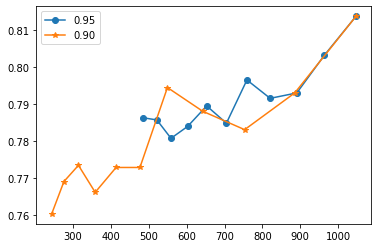

In [0]:
from matplotlib import pyplot as plt
plt.plot(np.array(p095_size)/1000,p095_acc, "o-",  label = '0.95')
plt.plot(np.array(p090_size)/1000, p090_acc, "*-",  label = '0.90')
plt.legend()